In [1]:
import torch
from torch import nn

import numpy as np
from PIL import Image
from skimage.util import random_noise
import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from collections import OrderedDict
from math import ceil
import time
import random
import glob


# Model

In [2]:
from Models import CustomHasher, SmallHasher, ResnetHasher

### Visualization Tools

In [3]:
# Visualize Data
class ShowTensor():
    def __call__(self, tensor):
        npimg = tensor.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
show_tensor = ShowTensor()
class ShowTriplet():
    def __call__(self, triplet, axes=True):
        npimgs = [ tensor.numpy() for tensor in triplet ] 
        fig, axs = plt.subplots(1,3, constrained_layout=True, figsize=(12,12))
        axs[0].imshow(np.transpose(npimgs[0], (1, 2, 0)), interpolation='nearest')
        axs[1].imshow(np.transpose(npimgs[1], (1, 2, 0)), interpolation='nearest')
        axs[2].imshow(np.transpose(npimgs[2], (1, 2, 0)), interpolation='nearest')
        axs[0].set_title("Anchor (A)")
        axs[1].set_title("Positive (P)")
        axs[2].set_title("Negative (N)")
        if not axes:
            axs[0].set_axis_off()
            axs[1].set_axis_off()
            axs[2].set_axis_off()
        plt.show()
show_triplet = ShowTriplet()

In [4]:
# Visualize Model
SmallHasher().visualize()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 32, 32]               0
              ReLU-3           [-1, 16, 32, 32]               0
       BatchNorm2d-4           [-1, 16, 32, 32]              32
       HasherBlock-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 20, 16, 16]           2,900
         MaxPool2d-7           [-1, 20, 16, 16]               0
              ReLU-8           [-1, 20, 16, 16]               0
       BatchNorm2d-9           [-1, 20, 16, 16]              40
      HasherBlock-10           [-1, 20, 16, 16]               0
           Conv2d-11             [-1, 28, 8, 8]           5,068
        MaxPool2d-12             [-1, 28, 8, 8]               0
             ReLU-13             [-1, 28, 8, 8]               0
      BatchNorm2d-14             [-1, 2

### Image Augmentation/Transforms

In [5]:
from skimage.io._plugins.pil_plugin import pil_to_ndarray, ndarray_to_pil
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, RandomGrayscale, ToTensor, ToPILImage
class ApplyOne:
    def __init__(self, *argv):
        if len(argv) == 0:
            raise AssertionError('Must take at least one transform as arguments.')
        self.transforms = argv
    def __call__(self, img):
        return random.choice(self.transforms)(img)

class RandomRotate:
    # Rotate by one of the given angles.
    def __init__(self, angles):
        self.angles = angles
        self.flip = RandomHorizontalFlip(.5)
    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(self.flip(x), angle)

class RandomFillCrop:
    def __init__(self, chance):
        self.chance = chance
        self.rcs = [ RandomCrop((64, 64), padding=4, fill=0), 
                     RandomCrop((64, 64), padding=4, fill=255) ] 
    def __call__(self, img):
        return random.choice(self.rcs)(img) if random.random() < self.chance else img

class Noise:
    def __init__(self):
        self.to_PIL = ToPILImage('RGB')
    def __call__(self, img):
        noise_type = random.random()
        if noise_type < .33:
            noise_type = 's&p'
        elif noise_type < .66:
            noise_type = 'speckle'
        elif noise_type < 1.:
            noise_type = 'gaussian'
        else:
            return img
        
        nd_img = np.array(img) / 255.0
        nd_noised = random_noise(np.asarray(nd_img), mode=noise_type, clip=True)
        img = ndarray_to_pil(nd_noised)
        return img

# Used in model
class ToRGBTensor:
    def __init__(self):
        self.tt = ToTensor()
    def __call__(self, img):
        return self.tt(img.convert('RGB'))

In [6]:
transforms = Compose([
    ApplyOne(Noise(), RandomGrayscale(1)),
    ApplyOne(RandomRotate(range(0, 360, 30)), RandomFillCrop(.8))
]) 

# Load Training Data

In [17]:
class TripletDataset(torch.utils.data.Dataset):    
    def __init__(self, directory, transforms, batch_size=64):
        self.transforms = transforms
        self.batch_size = batch_size
        
        self.file_list = glob.glob(f'{directory}/*.png')
        self.triplets_original = len(self.file_list) // 2
        self.num_batches = ceil(self.triplets_original / self.batch_size)

        self.tt = ToRGBTensor()
        
        print(f'Found {len(self.file_list)} images.')

    def __len__(self):
        return self.triplets_original

    # [A, P, N]
    def __getitem__(self, index):
        anchor = self.file_list[index]
        negative = self.file_list[self.triplets_original + index]
        
        A = Image.open(anchor)
        P = self.transforms(A)
        N = Image.open(negative)
        
        return [self.tt(A), self.tt(P), self.tt(N)]
    
    def generate_batches(self):
        triplets_retrieved = 0
        while True:
            tr_after_yield = triplets_retrieved + self.batch_size
            
            # Read image lists from disk and flatten
            triplets = [tensor
                        for triplet in [self.__getitem__(x) for x in range(triplets_retrieved, min(tr_after_yield, len(self)))] 
                        for tensor in triplet]
            
            yield torch.stack(triplets)

            triplets_retrieved = tr_after_yield
            
            if triplets_retrieved >= self.triplets_original:
                return

In [18]:
dataset = TripletDataset('TrainDataset', transforms)

Found 11049 images.


In [19]:
validationset = TripletDataset('ValidDataset', transforms)

Found 3684 images.


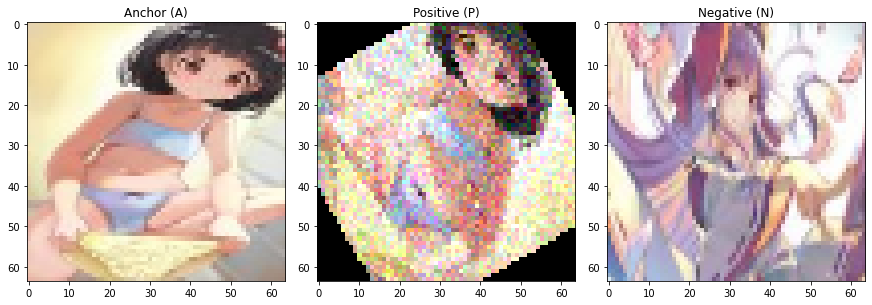

In [20]:
triplet = dataset[9]
show_triplet(triplet)

## Hyperparameters

## Triplet Loss:
$$L(\displaystyle A,\displaystyle P,\displaystyle N,\displaystyle \alpha) = max\Big( d(f(\displaystyle A), f(\displaystyle N)) − d(f(\displaystyle A), f(\displaystyle P)) + \displaystyle \alpha, 0 \Big)$$

Where:
* ${\displaystyle A}$ is an anchor input, 
* ${\displaystyle P}$ is a positive input of the same class as ${\displaystyle A}$, 
* ${\displaystyle N}$ is a negative input of a different class from ${\displaystyle A}$, 
* ${\displaystyle \alpha }$  is a margin between positive and negative pairs, 
* ${\displaystyle f}$ is an embedding onto a metric space (the model we're training), and 
* $d$ is a distance function on that space. (In this case L1 or L2 norm, Manhattan and Euclidean distance respectively).

Taken from FaceNet paper
https://arxiv.org/abs/1503.03832

## N-Tuple loss
Triplet loss as described above accomplishes unsupervised learning of embeddings. This is all well and good, but what if we wanted to up the ante a bit? Triplet loss pushes the embeddings of two images farther apart. But what if we wanted to push even more embeddings apart, probably more intelligently, in a single step? Behold my monstrosity, n-tuple loss.

As above, let $f$ be an embedding from the input space onto metric space, and $\alpha$ be the desired margin between positive and negative pairs. In this case, $f$ represents our model.

Let $A$ be a tuple of $n$ anchor inputs from separate classes, and $P$ be a tuple of $n$ corresponding positive matches from each class. 

Let the class of $a \in A$ be distinct from the class of $x \in A\cup B$ for $a \neq x$.

Let $S$ be a tuple of distances on the chosen metric space of length n.
Let $S_i = d(f(A_i), f(B_i))$ for $i \in 1..n$

Finally, 

$$L(\displaystyle A,\displaystyle B,\displaystyle \alpha) = \sum_{i=1}^{n} \sum_{j=i+1}^{n} \lbrack d(f(A_i),f(B_j)) - S_j + \alpha \rbrack_{+}.$$

In [21]:
# Model
model = SmallHasher()

# Loss
norm_margin = .4
norm_type = 'Manhattan'
loss_fn = nn.TripletMarginLoss(margin=norm_margin, p= 1 if norm_type=='Manhattan' else 2)

# Optimizer
opt = torch.optim.Adam(model.parameters(), lr=.01)

# Training Loop

In [22]:
print_batches = True

# Returns loss
def train_batch(model, batch, batchnum):
        batch_start_time = time.time()

        model.train()

        # Forward
        model.zero_grad()
        out_tensors = model.forward(batch)
        A = out_tensors[0::3]
        P = out_tensors[1::3]
        N = out_tensors[2::3]
        
        # Backward
        loss = loss_fn(A, P, N)
        loss.backward()
        opt.step()

        batch_end_time = time.time()
        
        loss_num = loss.item()

        if print_batches:
            batch_time = round(batch_end_time-batch_start_time, 2)
            num_batches = dataset.num_batches
            est_epoch_time_seconds = batch_time*num_batches
            est_epoch_time_minutes = round(est_epoch_time_seconds / 60, 2)
            print(f'\rCompleted train batch: {str(batch_num).rjust(4, " ")} of {num_batches} | \
Loss: {"{:6.4f}".format(loss_num)} | \
Time: {str(batch_time).rjust(6, " ")} (est. {"{:4.1f}".format(est_epoch_time_minutes)} min for epoch)', end='')
        return loss_num

# Returns loss
def valid_batch(model, batch, batch_num):
        batch_start_time = time.time()

        model.eval()
        with torch.no_grad():
                # Forward
                model.zero_grad()
                out_tensors = model.forward(vbatch)
                A = out_tensors[0::3]
                P = out_tensors[1::3]
                N = out_tensors[2::3]
        
                # Backward
                loss = loss_fn(A, P, N)
                batch_end_time = time.time()

                loss_num = loss.item()
        
        if print_batches:
            batch_time = round(batch_end_time-batch_start_time, 2)
            num_batches = validationset.num_batches
            est_epoch_time_seconds = batch_time*num_batches
            est_epoch_time_minutes = round(est_epoch_time_seconds / 60, 2)
            print(f'\rCompleted valid batch: {str(batch_num).rjust(4, " ")} of {num_batches} | \
Loss: {"{:6.4f}".format(loss_num)} | \
Time: {str(batch_time).rjust(6, " ")} (est. {"{:4.1f}".format(est_epoch_time_minutes)} min for epoch)', end='')
        return loss_num


In [23]:
epoch_avg_losses = []
# Train for 5 epochs
for epoch in range(1, 100):
    
    batch_num = 0
    batch_valid_losses = []
    
    # Training Batches
    epoch_start_time = time.time()
    for batch in dataset.generate_batches():
        batch_num += 1
        
        train_batch(model, batch, batch_num)
    
    # So carriage return prints train/valid on different lines
    print()

    # Validation batches
    batch_num = 0
    for vbatch in validationset.generate_batches():
        batch_num += 1

        loss_num = valid_batch(model, vbatch, batch_num)
        batch_valid_losses.append(loss_num)
    print()
    
    epoch_end_time = time.time()
    epoch_time_minutes = round((epoch_end_time - epoch_start_time) / 60, 2)
    epoch_average_valid_loss = sum(batch_valid_losses) / len(batch_valid_losses)
    print(f"""\
╔══════════════════════════════════════════════════════════════════╗\n║ \
End of Epoch: {str(epoch).rjust(3, " ")} | \
Validation Loss: {"{:7.4f}".format(epoch_average_valid_loss)} | \
Time: {str(epoch_time_minutes).rjust(6, " ")} min. ║\n\
╚══════════════════════════════════════════════════════════════════╝\n""")
    
    
    # Early Stopping
    if (epoch > 5):
        if (epoch_average_valid_loss > epoch_avg_losses[-1]):
            break # Exit training loop
    epoch_avg_losses.append(epoch_average_valid_loss)

Completed train batch:   39 of 87 | Loss: 0.0155 | Time:   0.35 (est.  0.5 min for epoch)

KeyboardInterrupt: 

# Export Model

In [ ]:
export_model = True
model_path = 'Models/model%s.zip' 


def next_path(path_pattern):
    i = 1
    while os.path.exists(path_pattern % i):
        i += 1
    return path_pattern % i

if export_model:
    fname = next_path(model_path)
    torch.save(model, fname)
    print(f'Saved model as: {fname}')